# 3. Support vector machine

## 3.1 はじめに

本ノートブックでは，[A tutorial on statistical-learning for scientific data processing](http://scikit-learn.org/stable/tutorial/statistical_inference/index.html)を参考に，[教師あり学習](https://github.com/haltaro/ml-tutorial/blob/master/02.intro_to_supervised.ipynb)の代表的な手法である[Support Vector Machine](https://ja.wikipedia.org/wiki/%E3%82%B5%E3%83%9D%E3%83%BC%E3%83%88%E3%83%99%E3%82%AF%E3%82%BF%E3%83%BC%E3%83%9E%E3%82%B7%E3%83%B3)（SVM）について学びます．

[Support vector machine](https://ja.wikipedia.org/wiki/%E3%82%B5%E3%83%9D%E3%83%BC%E3%83%88%E3%83%99%E3%82%AF%E3%82%BF%E3%83%BC%E3%83%9E%E3%82%B7%E3%83%B3)は，現在知られている手法の中でも認識性能が優れたモデルの一つであり，分類および回帰の両方に適用可能です．詳細は[栗田多喜夫，サポートベクターマシン入門](http://home.hiroshima-u.ac.jp/tkurita/lecture/svm.pdf)や[C. M. ビショップ，パターン認識と機械学習](http://amzn.asia/0OTDQtT)をご参照ください．

本ノートブックでは，以下の記号を用います．
* $\mathbf{x}_n$：$n$番目データの特徴ベクトル．
* $y_n$：$n$番目データの教師ラベル．$y_n \in \{-1, 1\}$．
* $\mathbf{w}$，$b$：ラベルを予測するためのパラメータ．
* $\hat{y}(\mathbf{x}_n)$：$n$番目のデータ$\mathbf{x}_n$に対するラベルの予測結果．$\hat{y}(\mathbf{x}_n) > 0$のときラベルを$y_n=1$と予測し，それ以外のときはラベルを$y_n=-1$と予測する．
* $\xi$：ソフトマージンSVMで用いるパラメータ．
* $\mathbf{\phi}(\mathbf{x}_n)$：$n$番目のデータの特徴ベクトル$\mathbf{x}_n$の写像後のベクトル．$\mathbf{x}_n$と$\mathbf{\phi}(\mathbf{x}_n)$の次元は必ずしも同じである必要はありません．

以下では，最も単純な**ハードマージン線形SVM**から，**ソフトマージン線形SVM**，そしてカーネルトリックを使った**非線形SVM**と，徐々に複雑なモデルを解説します．

## 3.2 ハードマージン線形SVM

### 3.2.1 主問題
特徴ベクトル$\mathbf{x_n}$に対して，下式でラベル$y_n \in \{-1, 1\}$を予測する問題を考えます．

$\hat{y}(\mathbf{x}_n) = \mathbf{w}^T \mathbf{x}_n + b$

$\hat{y}(\mathbf{x}_n) > 0$のときラベルを$y_n=1$と予測し，それ以外のときはラベルを$y_n=-1$と予測します．$\hat{y}=0$を満たす超平面を决定境界（Decision boundary）と呼びます．簡単のため，下図のように，すべての教師データに対して正しく分類するパラメータ$\mathbf{w}$，$b$が存在すると仮定します．

<img src="fig/hard_svm.png" width="480px">

すべての$n$について$y_n\hat{y}_n > 0$が成立することに注意すると，超平面$\hat{y}=0$から点$\mathbf{x}_n$までの距離は，下式で求められます．

$\dfrac{y_n\hat{y}(\mathbf{x}_n)}{||\mathbf{w}||} 
= \dfrac{y_n\left(\mathbf{w}^T\mathbf{x}_n+b \right)}{||\mathbf{w}||} $

超平面$\hat{y}=0$から最も近い点までの距離を**マージン**（Margin）と呼びます．我々の目的は，マージンを最大化するパラメータ$\mathbf{w}$および$b$を求めることです．

$\mathrm{argmax}_{\mathbf{w},b}\left\{
\dfrac{1}{||\mathbf{w}||}
\mathrm{min}_n
\left[y_n\left(\mathbf{w}^T\mathbf{x}_n+b\right)\right]
\right\}$

パラメータ$\mathbf{w}$および$b$を定数倍しても，超平面$\hat{y}=0$から点$\mathbf{x}_n$までの距離は変りません．よって，適切に定数倍することで，境界に最も近いデータについて，下式を成立させることができます．

$\mathrm{min}_n
\left[y_n\left(\mathbf{w}^T\mathbf{x}_n+b\right)\right]=1$

このとき，すべてのデータについて下式が成立します．

$y_n\left(\mathbf{w}^T\mathbf{x}_n+b \right)\geq 1$，$n=1,\dots,N$

以上から，次のように最適化問題を立式できます．

* minimize：$\dfrac{1}{2}||\mathbf{w}||^2$，
* subject to：$y_n\left(\mathbf{w}^T\mathbf{x}_n+b \right)\geq 1$，$n=1,\dots,N$

### 3.2.2 双対問題

このままでも解けますが，後述する非線形SVMへの拡張を容易にするため，[ラグランジュの未定乗数法](https://ja.wikipedia.org/wiki/%E3%83%A9%E3%82%B0%E3%83%A9%E3%83%B3%E3%82%B8%E3%83%A5%E3%81%AE%E6%9C%AA%E5%AE%9A%E4%B9%97%E6%95%B0%E6%B3%95)で[双対問題](https://ja.wikipedia.org/wiki/%E5%8F%8C%E5%AF%BE%E5%95%8F%E9%A1%8C)を求めます．ラグランジュ乗数$a_n \geq 0$を導入すると，下式のラグランジュ関数$L(\mathbf{w}, b, \mathbf{a})$を得ます．

$ L(\mathbf{w}, b, \mathbf{a}) =
 \dfrac{1}{2}||\mathbf{w}||^2 - 
 \sum_n^N a_n \left\{y_n\left(\mathbf{w}^T\mathbf{x}_n+b\right) -1 \right\}$

ここで，$\mathbf{a}=(a_1, a_2, \dots, a_N)^T$です．
$L(\mathbf{w}, b, \mathbf{a})$を$\mathbf{w}$と$b$について微分して，$0$に等しいと置くと，下式を得ます．

* $\mathbf{w}=\sum_n^N a_n y_n \mathbf{x}_n$
* $0 = \sum_n^N a_n y_n$

これらを$L(\mathbf{w}, b, \mathbf{a})$に代入して$\mathbf{w}$と$b$を消去すると，下式を得ます．

$ \tilde{L}(\mathbf{a}) =
 \sum_n^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N
 a_n a_m y_n y_m \mathbf{x}_n^T \mathbf{x}_m$

以上から，次の最適化問題を解くことで，最適な$\mathbf{a}=(a_1, a_2, \dots, a_N)^T$を求めることができます．

* maximize：$ \sum_n^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N
 a_n a_m y_n y_m \mathbf{x}_n^T \mathbf{x}_m$

* subject to：
  * $a_n \geq 0$，$n=1,\dots,N$
  * $\sum_n^N a_n y_n=0$

### 3.2.3 Support vector
ここで，[カルーシュ・クーン・カッター条件](https://ja.wikipedia.org/wiki/%E3%82%AB%E3%83%AB%E3%83%BC%E3%82%B7%E3%83%A5%E3%83%BB%E3%82%AF%E3%83%BC%E3%83%B3%E3%83%BB%E3%82%BF%E3%83%83%E3%82%AB%E3%83%BC%E6%9D%A1%E4%BB%B6)（KKT条件）を考えます．KKT条件とは，最適解であるための必要条件です．

* $a_n \geq 0$，$n=1,\dots,N$
* $y_n \hat{y}(\mathbf{x}_n)-1 \geq 0$，$n=1,\dots,N$
* $a_n \left\{y_n \hat{y}(\mathbf{x}_n)-1\right\}=0$，$n=1,\dots,N$

特に，最後の条件を**相補性条件**と呼びます．
相補性条件と$\mathbf{w}=\sum_n^N a_n y_n \mathbf{x}_n$より，最適な$\mathbf{w}$の計算に必要なのは，$y_n\hat{y}(\mathbf{x}_n)-1=0$を満たす決定境界に最も近いデータ集合のみであることがわかります．
このようなデータは**Support vector**と呼ばれます．また，最適な$b$は，相補性条件と$y(\mathbf{x})=\sum_{n \in N_S} a_n y_n \mathbf{x}_n^T \mathbf{x} + b$から計算できます．ただし，$N_S$はSupport vectorの添字からなる集合です．

* $\mathbf{w}=\sum_{n\in N_S} a_n y_n \mathbf{x}_n$
* $b = \dfrac{1}{\mid N_S \mid} \sum_{n\in N_S} \left(y_n - \sum_{m\in N_S}a_m y_m \mathbf{x}_n^T \mathbf{x}_m \right)$

理論的には，任意のSupport vector $\mathbf{x}_n$について$y_n\hat{y}(\mathbf{x}_n)=y_n\left(\sum_{m \in N_S} a_m y_m \mathbf{x}_m^T \mathbf{x}_n + b \right)= 1$を解けば$b$が求まりますが，数値計算の誤差の影響を減らすために，上式では全てのSupport vectorについて平均を取っています．

### 3.2.4 Demo
以下では，ハードマージン線形SVMの振る舞いを観察します．まず，必要なパッケージを`import`します．

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

分類用の人工データ`X`および`Y`を生成します．

In [21]:
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]] #特徴
Y = [0] * 20 + [1] * 20 #ラベル

SVMの学習およびプロットを一括して行う関数を定義します．パラメータ`C`および`kernel`については，3.3節以降でご紹介します．

In [28]:
def plot_svc(C=100, kernel='linear', title='Linear'):
    clf = svm.SVC(kernel=kernel, C=C)
    clf.fit(X, Y)
    
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = a * xx - (clf.intercept_[0]) / w[1]
    
    margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
    yy_down = yy - np.sqrt(1 + a ** 2) * margin
    yy_up = yy + np.sqrt(1 + a ** 2) * margin
    
    plt.plot(xx, yy, 'k-')
    plt.plot(xx, yy_down, 'k--')
    plt.plot(xx, yy_up, 'k--')
    
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=80, facecolors='none', zorder=10, edgecolors='k')
    plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired,
                edgecolor='k')
    
    plt.axis('tight')
    x_min, x_max = -4.8, 4.2
    y_min, y_max = -6, 6
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z, cmap=plt.cm.Paired)
    plt.xlim(x_min, x_max), plt.ylim(y_min, y_max)
    plt.xticks(()), plt.yticks(())
    plt.title('{} (C={})'.format(title, C))

それでは，ハードマージン線形SVMの学習結果をプロットします．`plot_svm`の引数はデフォルトで構いません．

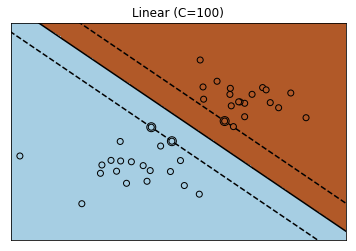

In [30]:
plot_svc()

図中の二重丸はSupport vectorを表します．

## 3.3 ソフトマージン線形SVM

<img src="fig/soft_svm.png" width="360px">



## 3.4 非線形SVM

<img src="fig/phi.png" width="480px">